In [2]:
import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Mon Feb 10 16:35:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080        Off |   00000000:0A:00.0 Off |                  N/A |
| 33%   39C    P8             22W /  225W |      42MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/tmp/ipykernel_2372637/2904596807.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


In [3]:
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [4]:
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [5]:
from mujoco_playground import registry
env = registry.load('CartpoleBalance')
env

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:14<00:00]


Checking out commit 5e6af47a49bf8ae27581615b54045107b20ce584
Successfully downloaded mujoco_menagerie


In [6]:
env_cfg = registry.get_default_config('CartpoleBalance')
env_cfg

action_repeat: 1
ctrl_dt: 0.01
episode_length: 1000
sim_dt: 0.01
vision: false
vision_config:
  enabled_geom_groups:
  - 0
  - 1
  - 2
  gpu_id: 0
  history: 3
  render_batch_size: 512
  render_height: 64
  render_width: 64
  use_rasterizer: false

In [8]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|██████████| 1001/1001 [00:01<00:00, 666.78it/s]


In [9]:
state.obs.device

CudaDevice(id=0)

In [10]:
from mujoco_playground.config import dm_control_suite_params
ppo_params = dm_control_suite_params.brax_ppo_config('CartpoleBalance')
ppo_params

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

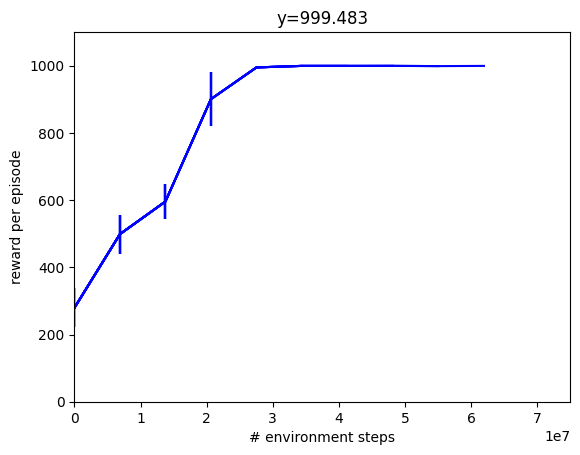

time to jit: 0:00:35.929365
time to train: 0:03:12.539019


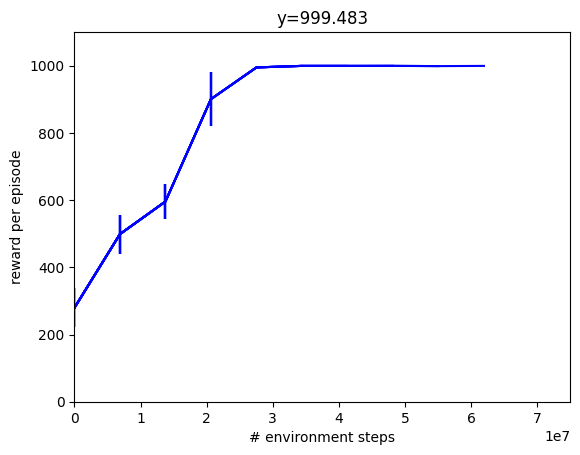

In [12]:
from mujoco_playground import wrapper

make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [13]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [14]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

100%|██████████| 1001/1001 [00:01<00:00, 769.46it/s]
